# Tutorial For Tensorflow 2.0 CISC/CMPE 452 / CISC 874 / COGS 400

This tutorial is split into two parts. The first part will go over a simple linear function optimization using tensorflow. The second part will go over using tensorflow 2.0 to solve the MNIST DIGIT classification challenge and has a useful example of how to load the data for MNIST into your python environment using tensorflow/keras.

In Tensorflow 2.0, the majority of the environment is in 'Eager Execution'. This means that, like typical python, it is a define by run environment. If you are worried about speed, training steps and tensor executions can be run inside a tf.funciton wrapped function. This will make tensorflow auto-graph and optimize the graph for the function execution.

Finally, I recommend always having the API for Tensorflow 2.0 up while coding, so here it is: [TF-2.0](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf)

In [0]:
!pip install tensorflow-gpu==2.0.0rc numpy tqdm matplotlib --no-cache-dir

     |████████████████████████████████| 380.5MB 1.9MB/s 
     |████████████████████████████████| 501kB 43.5MB/s 
     |████████████████████████████████| 4.3MB 35.7MB/s 


In [0]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [0]:
tf.__version__

'2.0.0-rc0'

# Linear Function Optimization

This section goes over creating a small dataset of a noisy linear function and using tensorflow 2.0 to solve it.

In [0]:
X = np.random.normal(0.0,0.1,1000).astype(np.float32)
noise = np.random.normal(0.0,0.5,1000)
X.shape

(1000,)

In [0]:
true_W = np.random.rand()*100
true_B = np.random.rand()*100

Y = (true_W*X + true_B + noise).astype(np.float32)
print("True_W: ",true_W)
print("True_B: ",true_B)
print("Shape: ",Y.shape)

True_W:  33.09200950692953
True_B:  98.35520464560571
Shape:  (1000,)


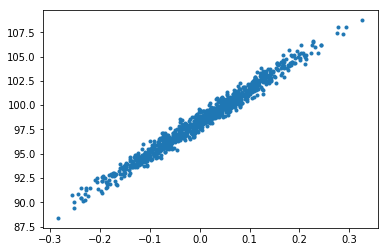

In [0]:
plt.plot(X[:],Y[:],'.')

In [0]:
class Model(object):
  def __init__(self):
    self.W = tf.Variable(5.0,dtype=tf.float32)
    self.B = tf.Variable(0.0,dtype=tf.float32)
  def __call__(self,x):
    return self.W * x + self.B
  
model = Model()

In [0]:
def loss(pred_y, target_y):
  return tf.reduce_mean(tf.square(pred_y - target_y))

In [0]:
@tf.function
def train(model,inputs,outputs,lr):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs),outputs)
  dW, db = t.gradient(current_loss,[model.W, model.B])
  model.W.assign_sub(lr * dW)
  model.B.assign_sub(lr * db)
  return current_loss

In [0]:
Ws, Bs = [], []
lr = 1
pbar = tqdm(range(1000))
for epoch in pbar:
  Ws.append(model.W.numpy())
  Bs.append(model.B.numpy())
  
  current_loss = train(model,X, Y,lr=lr)
  if epoch%100 == 0:
    lr *= 0.9
    pbar.set_description('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f lr=%1.4f' %
          (epoch, Ws[-1], Bs[-1], current_loss,lr))



Epoch 900: W=32.89 b=98.37, loss=0.26475 lr=0.3487: 100%|██████████| 1000/1000 [00:02<00:00, 407.57it/s]


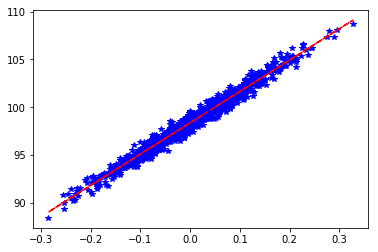

In [0]:
plt.plot(X,Y,'b*')
plt.plot(X,model(X),'r--')

# MNIST Challenge

This section uses tf.keras.datasets to load the MNIST dataset and TF2.0 to optimize a simple neural network to solve the digit classification challenge. This is a quick and easy way to create custom models and custom training loops. 

In [0]:
(train_x,train_y),(test_x,test_y) = tf.keras.datasets.mnist.load_data()
num_classes = 10
bs = 256
num_epochs = 10
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [0]:
train_x, test_x = train_x/255., test_x/255.
train_x = np.expand_dims(train_x,-1)
train_y = np.expand_dims(train_y,-1)
test_x = np.expand_dims(test_x,-1)
test_y = np.expand_dims(test_y,-1)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y)).shuffle(1000).batch(bs)
test_ds = tf.data.Dataset.from_tensor_slices((test_x,test_y)).shuffle(1000).batch(bs)

In [0]:
class MNIST_Model(tf.keras.Model):
    def __init__(self,num_classes = 10):
        super(MNIST_Model,self).__init__()
        self.num_classes = num_classes
        self.conv1 = tf.keras.layers.Conv2D(32,[3,3],padding='same',activation=tf.nn.relu)
        self.b1 = tf.keras.layers.BatchNormalization()
        self.m1 = tf.keras.layers.MaxPool2D((2,2),2)
        self.f = tf.keras.layers.Flatten()
        self.d = tf.keras.layers.Dense(128,activation=tf.nn.relu)
        self.o = tf.keras.layers.Dense(num_classes,activation=tf.nn.softmax)


    def call(self,x):
        x = self.conv1(x)
        x = self.b1(x)
        x = self.m1(x)
        x = self.f(x)
        x = self.o(x)
        return x

In [0]:
model = MNIST_Model(num_classes)

In [0]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [0]:
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [0]:
@tf.function
def train_step(inp, labels):
    with tf.GradientTape() as tape:
        preds = model(tf.cast(inp,tf.float32))
        loss = loss_obj(labels,preds)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_acc(labels,preds)



In [0]:
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    train_loss.reset_states()
    train_acc.reset_states()
    for inp,labels in train_ds:
        train_step(inp,labels)
    pbar.set_description('Epoch %2d: loss=%2.5f, acc=%2.5f' %
          (epoch,train_loss.result().numpy(),train_acc.result().numpy()))

Epoch  9: loss=0.03838, acc=0.98882: 100%|██████████| 10/10 [00:24<00:00,  2.22s/it]


In [0]:
@tf.function
def test_step(inp,labels):
    preds = model(inp)
    test_acc(labels,preds)

In [0]:
for inp,labels in test_ds:
    test_step(inp,labels)
print("Final accuracy: %.4f" %(test_acc.result().numpy()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final accuracy: 0.9823


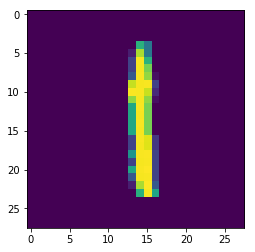

tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor(
[4.7426440e-08 9.9987626e-01 6.4554882e-07 4.2791197e-07 1.0465928e-04
 4.5724607e-07 1.4960106e-07 3.2765888e-06 1.2677482e-05 1.4385998e-06], shape=(10,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


In [0]:
inp,labels = next(test_ds.__iter__())
ind = np.random.randint(0,inp.shape[0])
plt.imshow(inp[ind,:,:,0])
plt.show()
print(labels[ind,...])
print(model(inp)[ind,...])
print(tf.argmax(model(inp)[ind,...]))